Download data

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Cam6b51nLp6vj7x1sTqEmChA-Q3xaRPP' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Cam6b51nLp6vj7x1sTqEmChA-Q3xaRPP" -O Data_for_demo.zip && rm -rf /tmp/cookies.txt
!unzip Data_for_demo.zip
!rm Data_for_demo.zip

--2021-06-01 12:17:52--  https://docs.google.com/uc?export=download&confirm=su&id=1Cam6b51nLp6vj7x1sTqEmChA-Q3xaRPP
Resolving docs.google.com (docs.google.com)... 142.250.101.139, 142.250.101.138, 142.250.101.102, ...
Connecting to docs.google.com (docs.google.com)|142.250.101.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘Data_for_demo.zip’

Data_for_demo.zip       [ <=>                ]   3.21K  --.-KB/s    in 0s      

2021-06-01 12:17:52 (51.3 MB/s) - ‘Data_for_demo.zip’ saved [3291]

Archive:  Data_for_demo.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of Data_for_demo.zip or
        Data_for_demo.zip.zip, and cannot find Data_for_demo.zip.ZIP, period.


In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1a8LR1XVcuusRrh1ce6qwKE8ZkwoL2oY0' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1a8LR1XVcuusRrh1ce6qwKE8ZkwoL2oY0" -O Model.zip && rm -rf /tmp/cookies.txt
!unzip Model.zip
!rm Model.zip

--2021-06-01 12:26:06--  https://docs.google.com/uc?export=download&confirm=G6Os&id=1a8LR1XVcuusRrh1ce6qwKE8ZkwoL2oY0
Resolving docs.google.com (docs.google.com)... 142.250.101.139, 142.250.101.138, 142.250.101.102, ...
Connecting to docs.google.com (docs.google.com)|142.250.101.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-1c-docs.googleusercontent.com/docs/securesc/r8mitu21s4tdsdgigr7j489mkl1jh87p/vrequqgunjuv6vd70e59l20r3rbshkvu/1622550300000/12975544805654496893/02441062332461995899Z/1a8LR1XVcuusRrh1ce6qwKE8ZkwoL2oY0?e=download [following]
--2021-06-01 12:26:06--  https://doc-10-1c-docs.googleusercontent.com/docs/securesc/r8mitu21s4tdsdgigr7j489mkl1jh87p/vrequqgunjuv6vd70e59l20r3rbshkvu/1622550300000/12975544805654496893/02441062332461995899Z/1a8LR1XVcuusRrh1ce6qwKE8ZkwoL2oY0?e=download
Resolving doc-10-1c-docs.googleusercontent.com (doc-10-1c-docs.googleusercontent.com)... 172.217.3.33, 2607:f8b0:4026:801::2001
Connec

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1RKG0xcrU0UQKYGbJktkUEmwHm4ZUESwH' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1RKG0xcrU0UQKYGbJktkUEmwHm4ZUESwH" -O S2S.py && rm -rf /tmp/cookies.txt

--2021-06-01 12:30:25--  https://docs.google.com/uc?export=download&confirm=jueT&id=1RKG0xcrU0UQKYGbJktkUEmwHm4ZUESwH
Resolving docs.google.com (docs.google.com)... 142.250.101.113, 142.250.101.139, 142.250.101.101, ...
Connecting to docs.google.com (docs.google.com)|142.250.101.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-ag-docs.googleusercontent.com/docs/securesc/g7lbemvnstn0et4osgrlt2s4k0qr2p7o/5kt1dse0ivbtscsccn6rvrm228kju8r1/1622550600000/12975544805654496893/13458071852262780760Z/1RKG0xcrU0UQKYGbJktkUEmwHm4ZUESwH?e=download [following]
--2021-06-01 12:30:25--  https://doc-0s-ag-docs.googleusercontent.com/docs/securesc/g7lbemvnstn0et4osgrlt2s4k0qr2p7o/5kt1dse0ivbtscsccn6rvrm228kju8r1/1622550600000/12975544805654496893/13458071852262780760Z/1RKG0xcrU0UQKYGbJktkUEmwHm4ZUESwH?e=download
Resolving doc-0s-ag-docs.googleusercontent.com (doc-0s-ag-docs.googleusercontent.com)... 216.58.192.65, 2607:f8b0:4026:802::2001
Conne

In [ ]:
import os
import sys
import time
import numpy as np 
import pandas as pd
import gc
import matplotlib.pyplot as plt
import re
import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import json
import pickle
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from nltk import sent_tokenize
import torch.nn.functional as F
import matplotlib.pyplot as plt
from rouge import Rouge


import math
import os
import random
import string

# Pytorch library for training
import torch
from torch import optim

import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Input vocabulary

In [ ]:
class Vocabulary:
    PAD_token = 0   # Used for padding short sentences
    SOS_token = 1   # Start-of-sentence token
    EOS_token = 2   # End-of-sentence token
    UNK_token = 3   # Out-of-vocabulary token

    def __init__(self, name):
        self.name = name
        self.word2index = {"pad":0, "sos":1, "eos":2, "unk":3}
        self.word2count = {"pad":0, "sos":0, "eos":0, "unk":0}              
        self.index2word = {0: "pad", 1: "sos", 2: "eos", 3: "unk"}
        self.num_words = 4
        self.num_sentences = 0
        self.longest_sentence = 0

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1
            
    def add_sentence(self, sentence):
        sentence_len = 0
        for word in sentence:           
            sentence_len += 1
            self.add_word(word)
        if sentence_len > self.longest_sentence:
            self.longest_sentence = sentence_len
        self.num_sentences += 1

    def to_word(self, index):
        return self.index2word[index]

    def to_index(self, word):
        return self.word2index[word]

In [ ]:
# text_dictionary
with open('Data_for_demo/text.dictionary', 'rb') as text_dictionary_file: #for S2S
    text_vocabulary = pickle.load(text_dictionary_file)
# headline_dictionary
with open('Data_for_demo/headline.dictionary', 'rb') as headline_dictionary_file: #for S2S
    headline_vocabulary = pickle.load(headline_dictionary_file)

In [ ]:
# text_dictionary
with open('Data_for_demo/text 1000.dictionary', 'rb') as text_dictionary_file: #for S2S+GAN
    text_vocabulary1 = pickle.load(text_dictionary_file)
# headline_dictionary
with open('Data_for_demo/headline 1000.dictionary', 'rb') as headline_dictionary_file: #for S2S+GAN
    headline_vocabulary1 = pickle.load(headline_dictionary_file)

In [ ]:
len(text_vocabulary.index2word), len(headline_vocabulary.index2word)

(57237, 18431)

In [ ]:
len(text_vocabulary1.index2word), len(headline_vocabulary1.index2word)

(7242, 1593)

Import Embeddings

In [ ]:
# Embeddings for the text dictionry
pre_train_weight = np.load('Data_for_demo/embedding.npy') #for S2S

# Embeddings for the headline dictionary
pre_train_weight_head = np.load('Data_for_demo/embedding_headline.npy') #for S2S

In [ ]:
# Embeddings for the text dictionry
pre_train_weight1 = np.load('Data_for_demo/embedding 1000.npy') #for S2S+GAN

# Embeddings for the headline dictionary
pre_train_weight_head1 = np.load('Data_for_demo/embedding_headline 1000.npy') #for S2S+GAN

In [ ]:
pre_train_weight.shape, pre_train_weight_head.shape

((57237, 200), (18431, 200))

In [ ]:
pre_train_weight1.shape, pre_train_weight_head1.shape

((7242, 200), (1593, 200))

Import test data

In [ ]:
## Set batch size and split data after padding to batches
def batch_dataloader(data, Batch_size):
    data_dataloader = torch.utils.data.DataLoader(data, batch_size=Batch_size, shuffle=False, num_workers=0)
#     for i in data_dataloader:
#         i = torch.transpose(i, 0 ,1)
#         print(data_dataloader)
    
    return data_dataloader

In [ ]:
testdata = torch.load('Data_for_demo/testdata_zip.pt') #for S2S

In [ ]:
testdata1 = torch.load('Data_for_demo/testdata_zip1000.pt') #for S2S+GAN

In [ ]:
testloader = batch_dataloader(testdata, 30) #for S2S and S2S+GAN

In [ ]:
testloader1 = batch_dataloader(testdata1, 2)#for pgn

Parameters

In [ ]:
input_size = int(len(text_vocabulary.index2word.keys()))
output_size = int(len(headline_vocabulary.index2word.keys()))

enc_emb_size = 200
dec_emb_size = 200
hid_size = 128

n_layers = 2
enc_dropout = 0.1
dec_dropout = 0.1

Seq-to-Seq

In [ ]:
from S2S import *

In [ ]:
encoder = Encoder1(input_size, enc_emb_size, hid_size, n_layers, enc_dropout, pre_train_weight)
decoder = Decoder1(output_size, dec_emb_size, hid_size, n_layers, dec_dropout, pre_train_weight_head)
seq2seq = Seq2Seq1(encoder, decoder, device, pre_train_weight)
seq2seq

Seq2Seq1(
  (encoder): Encoder1(
    (lstm): LSTM(200, 128, num_layers=2, dropout=0.1)
  )
  (decoder): Decoder1(
    (lstm): LSTM(200, 128, num_layers=2, dropout=0.1)
    (out): Linear(in_features=128, out_features=18431, bias=True)
  )
)

In [ ]:
seq2seq.load_state_dict(torch.load('Model/tut1-model.pt'))#Call the model with the best loss of validation

<All keys matched successfully>

In [ ]:
%%time
outputs = []
target = []
for text_batch, hl_batch, text_len, headline_len in testloader:
    text_batch = torch.transpose(text_batch, 0, 1) 
    hl_batch = torch.transpose(hl_batch, 0, 1)
    text_batch = text_batch[:text_len.max()]
    hl_batch = hl_batch[:headline_len.max()]
    with torch.no_grad():
        a = seq2seq(text_batch, text_len, hl_batch, teacher_forcing_ratio=0)
        a = a.argmax(2)
    for i in range(a.shape[1]):
        outputs.append(' '.join([headline_vocabulary.index2word[j] for j in a[:,i].numpy() if (j != 0) & (j != 1) & (j != 2)]))
        target.append(' '.join([headline_vocabulary.index2word[j] for j in hl_batch[:,i].numpy() if (j != 0) & (j != 1) & (j != 2)])) 

CPU times: user 1min 9s, sys: 617 ms, total: 1min 9s
Wall time: 1min 9s


In [ ]:
rouge = Rouge()
r1 = [rouge.get_scores(o, t)[0]["rouge-1"]['r'] for o, t in zip(outputs, target)]
r2 = [rouge.get_scores(o, t)[0]["rouge-2"]['r'] for o, t in zip(outputs, target)]
rl = [rouge.get_scores(o, t)[0]["rouge-l"]['r'] for o, t in zip(outputs, target)]

In [ ]:
rouge_11 = np.array(r1).mean()
rouge_21 = np.array(r2).mean()
rouge_l1 = np.array(rl).mean()

In [ ]:
trian1 = np.load('Data_for_demo/train loss 128.npy')
val1 = np.load('Data_for_demo/val loss 128.npy')

Text(0.5, 1.0, 'Seq-to-Seq 128 with GloVe embedding')

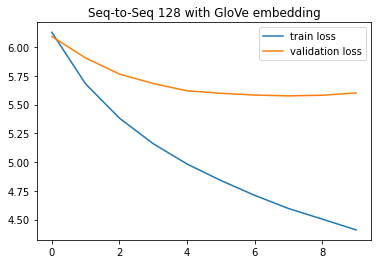

In [ ]:
n = range(len(trian1))
plt.plot(n,trian1)
plt.plot(n,val1)
plt.legend(['train loss','validation loss'])
plt.title('Seq-to-Seq 128 with GloVe embedding')

Hidden state with size 256

In [ ]:
hid_size1 = 256

In [ ]:
encoder1 = Encoder1(input_size, enc_emb_size, hid_size1, n_layers, enc_dropout, pre_train_weight)
decoder1 = Decoder1(output_size, dec_emb_size, hid_size1, n_layers, dec_dropout, pre_train_weight_head)
seq2seq1 = Seq2Seq1(encoder1, decoder1, device, pre_train_weight)
seq2seq1

Seq2Seq1(
  (encoder): Encoder1(
    (lstm): LSTM(200, 256, num_layers=2, dropout=0.1)
  )
  (decoder): Decoder1(
    (lstm): LSTM(200, 256, num_layers=2, dropout=0.1)
    (out): Linear(in_features=256, out_features=18431, bias=True)
  )
)

In [ ]:
seq2seq1.load_state_dict(torch.load('Model/tut1-model2.pt'))

<All keys matched successfully>

In [ ]:
%%time
outputs2 = []
for text_batch, hl_batch, text_len, headline_len in testloader:
    text_batch = torch.transpose(text_batch, 0, 1) 
    hl_batch = torch.transpose(hl_batch, 0, 1)
    text_batch = text_batch[:text_len.max()]
    hl_batch = hl_batch[:headline_len.max()]
    with torch.no_grad():
        a = seq2seq1(text_batch, text_len, hl_batch, teacher_forcing_ratio=0)
        a = a.argmax(2)
    for i in range(a.shape[1]):
        outputs2.append(' '.join([headline_vocabulary.index2word[j] for j in a[:,i].numpy() if (j != 0) & (j != 1) & (j != 2)]))

CPU times: user 1min 43s, sys: 1.25 s, total: 1min 44s
Wall time: 1min 44s


In [ ]:
r12 = [rouge.get_scores(o, t)[0]["rouge-1"]['r'] for o, t in zip(outputs2, target)]
r22 = [rouge.get_scores(o, t)[0]["rouge-2"]['r'] for o, t in zip(outputs2, target)]
rl2 = [rouge.get_scores(o, t)[0]["rouge-l"]['r'] for o, t in zip(outputs2, target)]

In [ ]:
rouge_13 = np.array(r12).mean()
rouge_23 = np.array(r22).mean()
rouge_l3 = np.array(rl2).mean()

In [ ]:
trian2 = np.load('Data_for_demo/train loss 256.npy')
val2 = np.load('Data_for_demo/val loss 256.npy')

Text(0.5, 1.0, 'Seq-to-Seq 256 with GloVe embedding')

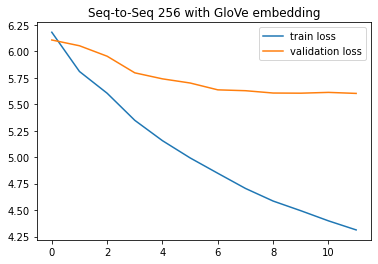

In [ ]:
n = range(len(trian2))
plt.plot(n,trian2)
plt.plot(n,val2)
plt.legend(['train loss','validation loss'])
plt.title('Seq-to-Seq 256 with GloVe embedding')

nn.Embedding ('tut1-model2.pt') 

In [ ]:
#S2Snn.txt obtained from Seq2SeqnnEmbedding.ipynb
outputs1 = []
f = open("Data_for_demo/S2Snn.txt","r")
line = f.readlines()
for a in line:
    outputs1.append(a)

In [ ]:
r11 = [rouge.get_scores(o, t)[0]["rouge-1"]['r'] for o, t in zip(outputs1, target)]
r21 = [rouge.get_scores(o, t)[0]["rouge-2"]['r'] for o, t in zip(outputs1, target)]
rl1 = [rouge.get_scores(o, t)[0]["rouge-l"]['r'] for o, t in zip(outputs1, target)]

In [ ]:
rouge_12 = np.array(r11).mean()
rouge_22 = np.array(r21).mean()
rouge_l2 = np.array(rl1).mean()

In [ ]:
trian3 = np.load('Data_for_demo/train loss nn 128.npy')
val3= np.load('Data_for_demo/val loss nn 128.npy')

Text(0.5, 1.0, 'Seq-to-Seq 128 with nn.embedding')

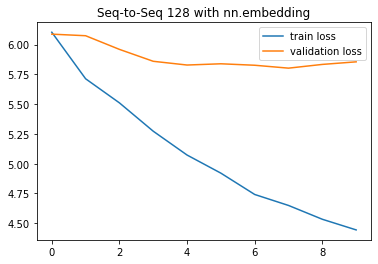

In [ ]:
n = range(len(trian3))
plt.plot(n,trian3)
plt.plot(n,val3)
plt.legend(['train loss','validation loss'])
plt.title('Seq-to-Seq 128 with nn.embedding')

In [ ]:
print('Seq-to-Seq using Gloves embedding with hidden state size = {:.0f}.'.format(hid_size))
print('ROUGE-1: {:.3f} on test data.'.format(100*np.array(rouge_11)))
print('ROUGE-2: {:.3f} on test data.'.format(100*np.array(rouge_21)))
print('ROUGE-l: {:.3f} on test data.'.format(100*np.array(rouge_l1)))
print('============================================================')
print('Seq-to-Seq using nn.Embedding with hidden state size = {:.0f}.'.format(hid_size))
print('ROUGE-1: {:.3f} on test data.'.format(100*np.array(rouge_12)))
print('ROUGE-2: {:.3f} on test data.'.format(100*np.array(rouge_22)))
print('ROUGE-l: {:.3f} on test data.'.format(100*np.array(rouge_l2)))
print('============================================================')
print('Seq-to-Seq using Gloves embedding with hidden state size = {:.0f}.'.format(hid_size1))
print('ROUGE-1: {:.3f} on test data.'.format(100*np.array(rouge_13)))
print('ROUGE-2: {:.3f} on test data.'.format(100*np.array(rouge_23)))
print('ROUGE-l: {:.3f} on test data.'.format(100*np.array(rouge_l3)))

Seq-to-Seq using Gloves embedding with hidden state size = 128.
ROUGE-1: 13.289 on test data.
ROUGE-2: 3.081 on test data.
ROUGE-l: 13.069 on test data.
Seq-to-Seq using nn.Embedding with hidden state size = 128.
ROUGE-1: 11.328 on test data.
ROUGE-2: 2.242 on test data.
ROUGE-l: 11.058 on test data.
Seq-to-Seq using Gloves embedding with hidden state size = 256.
ROUGE-1: 13.413 on test data.
ROUGE-2: 3.129 on test data.
ROUGE-l: 13.150 on test data.


Seq-to-Seq + GAN 

In [ ]:
input_size = int(len(text_vocabulary1.index2word.keys()))
output_size = 1386

enc_emb_size = 200
dec_emb_size = 200
hid_size = 128

n_layers = 2
enc_dropout = 0.1
dec_dropout = 0.1

In [ ]:
encoder2 = Encoder1(input_size, enc_emb_size, hid_size, n_layers, enc_dropout, pre_train_weight1)
decoder2 = Decoder1(output_size, dec_emb_size, hid_size, n_layers, dec_dropout, pre_train_weight_head1)
seq2seq2 = Seq2Seq1(encoder2, decoder2, device, pre_train_weight)
seq2seq2

Seq2Seq1(
  (encoder): Encoder1(
    (lstm): LSTM(200, 128, num_layers=2, dropout=0.1)
  )
  (decoder): Decoder1(
    (lstm): LSTM(200, 128, num_layers=2, dropout=0.1)
    (out): Linear(in_features=128, out_features=1386, bias=True)
  )
)

In [ ]:
seq2seq2.load_state_dict(torch.load('Model/model1.pt'))#Call the model with the best loss of validation

<All keys matched successfully>

In [ ]:
outputs3 = []
target3 = []
for text_batch, hl_batch, text_len, headline_len in testloader1:
    text_batch = torch.transpose(text_batch, 0, 1) 
    hl_batch = torch.transpose(hl_batch, 0, 1)
    text_batch = text_batch[:text_len.max()]
    hl_batch = hl_batch[:headline_len.max()]
    with torch.no_grad():
        a = seq2seq2(text_batch, text_len, hl_batch, teacher_forcing_ratio=0)
        a = a.argmax(2)
    for i in range(a.shape[1]):
        outputs3.append(' '.join([headline_vocabulary1.index2word[j] for j in a[:,i].numpy() if (j != 0) & (j != 1) & (j != 2)]))
        target3.append(' '.join([headline_vocabulary1.index2word[j] for j in hl_batch[:,i].numpy() if (j != 0) & (j != 1) & (j != 2)])) 

In [ ]:
r13 = [rouge.get_scores(o, t)[0]["rouge-1"]['r'] for o, t in zip(outputs3, target3)]
r23 = [rouge.get_scores(o, t)[0]["rouge-2"]['r'] for o, t in zip(outputs3, target3)]
rl3 = [rouge.get_scores(o, t)[0]["rouge-l"]['r'] for o, t in zip(outputs3, target3)]

In [ ]:
rouge_14 = np.array(r13).mean()
rouge_24 = np.array(r23).mean()
rouge_l4 = np.array(rl3).mean()

A comparison with Seq-to-Seq with 1000 data (Model in tut1-model3.pt)

In [ ]:
outputs4 = []
f = open("Data_for_demo/S2S1000.txt","r")
line = f.readlines()
for a in line:
    outputs4.append(a)

In [ ]:
r14 = [rouge.get_scores(o, t)[0]["rouge-1"]['r'] for o, t in zip(outputs4, target3)]
r24 = [rouge.get_scores(o, t)[0]["rouge-2"]['r'] for o, t in zip(outputs4, target3)]
rl4 = [rouge.get_scores(o, t)[0]["rouge-l"]['r'] for o, t in zip(outputs4, target3)]

In [ ]:
rouge_15 = np.array(r14).mean()
rouge_25 = np.array(r24).mean()
rouge_l5 = np.array(rl4).mean()

In [ ]:
print('Here because of the limit of time, we only trained the data on a smaller set.')
print('Seq-to-Seq + GAN using Gloves embedding with hidden state size = {:.0f} for 1000 data.'.format(hid_size))
print('ROUGE-1: {:.3f} on test data.'.format(100*np.array(rouge_14)))
print('ROUGE-2: {:.3f} on test data.'.format(100*np.array(rouge_24)))
print('ROUGE-l: {:.3f} on test data.'.format(100*np.array(rouge_l4)))
print('============================================================')
print('Seq-to-Seq using Gloves embedding with hidden state size = {:.0f} for 1000 data.'.format(hid_size))
print('ROUGE-1: {:.3f} on test data.'.format(100*np.array(rouge_15)))
print('ROUGE-2: {:.3f} on test data.'.format(100*np.array(rouge_25)))
print('ROUGE-l: {:.3f} on test data.'.format(100*np.array(rouge_l5)))

Here because of the limit of time, we only trained the data on a smaller set.
Seq-to-Seq + GAN using Gloves embedding with hidden state size = 128 for 1000 data.
ROUGE-1: 8.971 on test data.
ROUGE-2: 0.000 on test data.
ROUGE-l: 8.791 on test data.
Seq-to-Seq using Gloves embedding with hidden state size = 128 for 1000 data.
ROUGE-1: 7.037 on test data.
ROUGE-2: 0.000 on test data.
ROUGE-l: 6.845 on test data.


Demo

In [ ]:
artical = []
for text_batch, hl_batch, text_len, headline_len in testloader:
    for i in range(hl_batch.shape[0]):
        artical.append(' '.join([text_vocabulary.index2word[j] for j in text_batch[i,:].numpy() if (j != 0) & (j != 1) & (j != 2)]))

In [ ]:
for i in range(6000,6005):
    print('text:')
    print(artical[i])
    print('======================================================================================')
    print('target summary:')
    print(target[i])
    print('======================================================================================')
    print('our summary:')
    print(outputs1[i])

text:
if your symptoms indicate lyme disease and you are in an area where lyme disease is prevalent your doctor should test you for the disease the cdc suggests that labs use a twostep blood testing procedure for lyme disease your doctor should send your blood to a lab to get this testing
target summary:
get diagnosed with lyme disease
our summary:
ask your doctor about your doctor

text:
with this type of neuroma there is an area of raised sensitivity which may result in pain it develops due to the physical injury to a nerve the most common cecause of this neuroma is surgery but it may also be cecaused by cuts and damage done to the nerve by needles
target summary:
know that traumatic unk may be a result of surgery or other physical injury
our summary:
know that symptoms are a

text:
living through steps one through five makes you entirely ready you just need to recognize this and know that your defects can be removed share your defects with others andor your higher power and be ready